## Validate

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from mnist import MNIST

In [18]:
mndata = MNIST('data')
test_y = mndata.load_testing()[1]

In [37]:
tmp_list = []
for i in range(8):
    tmp = pd.read_csv('results_'+str(i))[['0']]
    tmp['model'] = i
    tmp['real'] = pd.Series(test_y)
    tmp_list.append(tmp)

In [38]:
df = pd.concat(tmp_list)
df.columns = ['pred', 'model', 'real']
df.loc[df['pred'] == df['real'], 'ok'] = 1
df['ok'] = df['ok'].fillna(0)

In [39]:
df.head(5)

,pred,model,real,ok
0,7,0,7,1.0
1,2,0,2,1.0
2,1,0,1,1.0
3,0,0,0,1.0
4,4,0,4,1.0


### Compare accuracy

In [40]:
df[['model', 'ok']]\
    .groupby('model')\
    .sum()\
    .apply(lambda x: x / len(test_y) * 100)

,ok
model,
0,98.90
1,98.88
2,98.46
3,97.84
4,98.84
5,98.43
6,98.55
7,94.83


In [41]:
history_container = []
for i in range(7):
    history_container.append(pd.read_csv('history_'+str(i))) 

### Compare losses

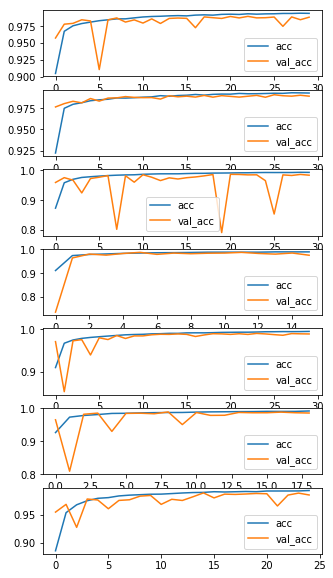

In [42]:
fig, axes = plt.subplots(7,1)
for i in range(7):
    history_container[i][['acc', 'val_acc']].plot(ax = axes[i], figsize = (5,10))

4 of them could be trained longer

### Voting

I want to vote accordingly to weight which I can calculate from accuracy - the better accuracy model has, the bigger weight

In [66]:
weights = df[['model', 'ok']]\
    .groupby('model')\
    .sum()\
    .apply(lambda x: x/80000)\
    .to_dict()['ok']

In [50]:
pivoted = df[['model', 'pred']]\
    .reset_index()\
    .pivot('index', 'model', 'pred')

In [77]:
def vote(row):
    if len(set(row)) == 1:
        return list(set(row))[0]
    else:
        row_voting = {0: 0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
        for i, el in enumerate(row):
            row_voting[el] += weights[i]
        return sorted(row_voting.items(), key = lambda kv : kv[1], reverse = True)[0][0]

In [83]:
final = pd.concat([
    pd.Series(pivoted.apply(vote, axis = 1), name = 'pred'),
    pd.Series(test_y, name = 'real'),
], axis = 1)

In [85]:
final.head(3)

,pred,real
index,,
0,7,7
1,2,2
2,1,1


In [86]:
final.loc[final['pred'] == final['real'], 'ok'] = 1
final['ok'] = final['ok'].fillna(0)

In [89]:
final['ok'].sum()/100

99.12

98.9 Was the best model, combined they score at 99.12%